# CC3001 Otoño 2021 Tarea 4
# Cálculo de derivadas de fórmulas representadas mediante árboles
## Profesores
Sección 1 Iván Sipirán • Sección 2 Patricio Poblete • Sección 3 Nelson Baloian

Pablo González Aguilera
20.973.277-7 Sección 2


El objetivo de esta tarea es aprender a procesar la información de árboles que representan fórmulas. Hay muchas cosas que uno puede hacer con estos árboles, y en esta tarea nos enfocaremos en particular en calcular la derivada de una fórmula respecto de una variable dada.

Específicamente, el problema es: dado un árbol que representa una fórmula, construir y retornar otro árbol que representa la derivada de la primera fórmula respecto de una variable dada.

La fórmula se entrega en notación de infijo (normal). En esta fórmula,
los operadores de menor prioridad son la suma (``+``) y la resta (``-``), de igual prioridad entre sí, luego vienen la multiplicación (``*``) y la división (``/``), también de igual prioridad entre sí, y finalmente el operador de mayor prioridad es la elevación a potencia (``^``). También se puede usar paréntesis. Para simplificar no usaremos el operador "menos unario". **Nota importante**: Para no complicar excesivamente las cosas, supondremos que en la elevación a potencia el exponente no contiene la variable respecto de la cual se está derivando.

A continuación usted encontrará las clases ``Nodoi``, ``Nodoe`` y ``Arbol`` que implementan árboles que representan fórmulas. La clase ``Arbol`` viene con un constructor que recibe un string como parámetro, el cual contiene una fórmula, y este constructor se encarga de transformar la fórmula de string a árbol, de modo que usted no necesita preocuparse de eso. Para simplificar, la fórmula solo podrá contener variables de una sola letra, números de un solo dígito, y sin espacios.

Usted tiene que implementar para la clase ``Arbol`` y para los nodos una función ``derivada`` que al ser invocada indicando el nombre de una variable, retorne un árbol que represente la derivada de la fórmula respectiva.

En este enunciado vienen funciones ``derivada`` triviales, que simplemente retornan la misma fórmula, sin derivarla. Usted debe reemplazarlas por la implementación correcta


In [2]:
!pip install aed-utilities

You should consider upgrading via the 'c:\users\pablo\pyver\py392\python.exe -m pip install --upgrade pip' command.


In [3]:
import aed_utilities as aed
from copy import copy

#Nodo interno
class Nodoi:
    def __init__(self, izq, info, der):
        self.izq=izq
        self.info=info
        self.der=der
    def postorden(self):
        self.izq.postorden()   
        self.der.postorden()
        print(self.info, end=" ")


    def derivada(self,x):

        if self.info == "+" or self.info == "-":
            self.izq = self.izq.derivada(x)
            self.der = self.der.derivada(x)

        if self.info == "*":
           
           #No quiero aliasing ni cosas raras :(
           #Acá ocupo la copia para no tener problemas de punteros que se me modifiquen
           izquierdoOriginal = copy(self.izq)
           derechoOriginal = copy(self.der)

            # Regla de la derivada de un producto
           self.info = "+"
           self.izq =  Nodoi(self.izq.derivada(x), "*", derechoOriginal)
           self.der =  Nodoi(self.der.derivada(x), "*", izquierdoOriginal) 

        if self.info == "/":
           
           #CUIDADO CON EL ALIASING ACA QUE OCUPAS EL DERECHOORIGINAL MAS DE UNa VEZ (al parecer funca igual, vamos chile)
           izquierdoOriginal = copy(self.izq)
           derechoOriginal = copy(self.der)

            # Regla de la derivada de un cociente
           self.info = "/"
           self.izq =  Nodoi(Nodoi(self.izq.derivada(x), "*", derechoOriginal), "-", Nodoi(self.der.derivada(x),"*", izquierdoOriginal)) #Numerador en la regla del cuociente
           self.der =  Nodoi(derechoOriginal, "^", Nodoe(2)) #denominador va al cuadrado

        if self.info == "^":
            
            #Juan segura vivió muchos años (su RAM no tanto si)
            izquierdoOriginal = copy(self.izq)
            derechoOriginal = copy(self.der)


            #Regla exponente entero x^n -> (n)*(x^(n-1))
            self.info = "*"
            # self.der = Nodoe(self.der) Básicamente puedo dejar el lado del exponente como estaba (pues la multiplicacion conmuta) (en vez de (n)*(x^(n-1)), estoy computando (x^(n-1))*(n) )
            self.izq = Nodoi(izquierdoOriginal, "^", Nodoi(derechoOriginal,"-", Nodoe(1))) # Lo multiplico por el numero elevado a uno menos

        return self


# Nodo externo
class Nodoe:
    def __init__(self, info):
        self.info=info
    def postorden(self):
        print(self.info, end=" ")

    def derivada(self,x):
        # Me van a quedar en los nodos externos solamente o la variable solita (derivada 1), o una constante con derivada 0
        return Nodoe(1) if self.info == str(x) else Nodoe(0)



#Toma un string de tipo "ax+b" y lo pasa a arbol binario
class Arbol:
    def __init__(self,formula):
        if type(formula)!=str: # se supone que viene el árbol ya construído
          self.raiz=formula
          return

        # la fórmula viene en forma de string
        global k
        global s
        s=formula+";" # agregamos una marca de fin de la entrada
        k=0 # indica próximo caracter por procesar
        # definimos funciones para analizar la fórmula
        def expresion(): # retorna puntero a la raíz de un árbol que representa a la fórmula s
            global k
            global s
            a=factor()
            while s[k]=="+" or s[k]=="-":
                op=s[k]
                k+=1
                b=factor()
                a=Nodoi(a,op,b)
            return a
        def factor():
            global k
            global s
            a=termino()
            while s[k]=="*" or s[k]=="/":
                op=s[k]
                k+=1
                b=termino()
                a=Nodoi(a,op,b)
            return a
        def termino():
            global k
            global s
            a=primario()
            if s[k]=="^":
                op=s[k]
                k+=1
                b=termino()
                a=Nodoi(a,op,b)
            return a
        def primario(): # posible constante, variable o formula parentizada
            global k
            global s
            if s[k].isalpha() or s[k].isdigit():
                a=Nodoe(s[k])
                k+=1
                return a
            if s[k]=="(": # fórmula parentizada
                k+=1
                a=expresion()
                if s[k]!=")":
                    print("Error: Falta cierra paréntesis: "+formula[k:])
                    assert False
                k+=1
                return a
            print("Error: Falta variable, número o abre paréntesis: "+formula[k:])
            assert False
              
        a=expresion()
        if s[k]!=";":
            print("Error: Basura al final de la fórmula: "+formula[k:])
            assert False                
        self.raiz=a
    
    def derivada(self,x):
        return Arbol(self.raiz.derivada(x))
      
    def dibujar(self):
      btd = aed.BinaryTreeDrawer(fieldData="info", fieldLeft="izq", fieldRight="der",classNone=Nodoe )
      btd.draw_tree(self, "raiz")


def probar_derivada(formula,x):
    f=Arbol(formula)
    print("Fórmula original:")
    f.dibujar()
    g=f.derivada(x)
    print("Derivada respecto de "+x+":")
    g.dibujar()




A continuación probamos esta funcionalidad con varias fórmulas de ejemplo. Para ver si el árbol fue construido correctamente, lo dibujaremos, y también dibujaremos el árbol resultante después del cálculo de la derivada.

In [7]:
def probar_derivada(formula,x):
    f=Arbol(formula)
    print("Fórmula original:")
    f.dibujar()
    g=f.derivada(x)
    print("Derivada respecto de "+x+":")
    g.dibujar()

In [1]:
probar_derivada("x+1","x")

NameError: name 'probar_derivada' is not defined

Fórmula original:


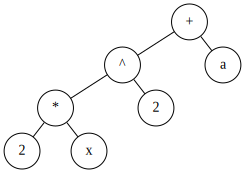

Error: Could not open "lista.gv.pdf" for writing : Permission denied
Derivada respecto de x:


CalledProcessError: Command '['dot', '-Kneato', '-Tpdf', '-O', 'lista.gv']' returned non-zero exit status 1. [stderr: b'Error: Could not open "lista.gv.pdf" for writing : Permission denied\r\n']

In [6]:
probar_derivada("(2*x)^2+a","x")

Fórmula original:


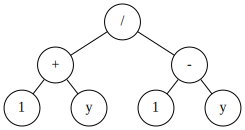

Derivada respecto de y:


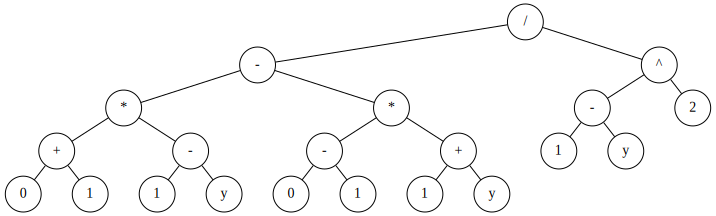

In [9]:
probar_derivada("(1+y)/(1-y)","y")

## Simplificaciones

Como habrá visto, las fórmulas resultantes no son muy sencillas, pero también es obvio que se se podrían simplificar para que quedaran mucho más presentables. A continuación, proponga y describa cómo podrían implementarse algunas simplificaciones. Piense recursivamente. No es necesario que las implemente, pero si se atreve, agregue un método ``simplificar`` y pruébelo dibujando el árbol resultante.

## ¿Qué hay que entregar?

Usted debe entregar este mismo archivo, modificado de acuerdo a lo que se pide. Haga todos los cambios necesarios para explicar y documentar adecuadamente su código. No olvide poner su nombre.